# New York City Taxi Fare Prediction

![](https://i.imgur.com/ecwUY8F.png)

Dataset Link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction

We'll train a machine learning model to predict the fare for a taxi ride in New York city given information like pickup date & time, pickup location, drop location and no. of passengers. 

This dataset is taken from a [Kaggle competition](ttps://www.kaggle.com/c/new-york-city-taxi-fare-prediction) organized by Google Cloud. It contains over 55 millions rows of training data. We'll attempt to achieve a respectable score in the competition using just a fraction of the data. Along the way, we'll also look at some practical tips for machine learning. PMost of the ideas & techniques covered in this notebook are derived from other public notebooks & blog posts.



Here's an outline of the project:
1. Download the dataset 
2. Explore and analyze the dataset
3. Prepare the dataset for ML training 
4. Train hardcoded and baseline models
5. Make predictions
6. Perform feature Engineering 
7. Train and evaluate different models
8. Tune hyperparameters for the base models


Dataset link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview


As the dataset is very large, I have already downloaded and viewed it on my local system. Here, I am loading only 1% of the data with selected columns and data types.

## Loading Training Set

Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:

- Ignore the `key` column
- Parse pickup datetime while loading data 
- Specify data types for other columns
   - `float32` for geo coordinates
   - `float32` for fare amount
   - `uint8` for passenger count
- Work with a 1% sample of the data (~500k rows)

We can apply these optimizations while using [`pd.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [3]:
import pandas as pd
import random

In [4]:
sample_frac = 0.01

In [5]:
%%time
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'passenger_count': 'uint8'
}

def skip_row(row_idx):
    if row_idx == 0:
        return False
    return random.random() > sample_frac

random.seed(42)
df = pd.read_csv('train_new_york_city_taxi_fare.csv', 
                 usecols=selected_cols, 
                 dtype=dtypes, 
                 parse_dates=['pickup_datetime'], 
                 skiprows=skip_row)

CPU times: total: 32.2 s
Wall time: 1min 9s


In [6]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755481,1
1,8.0,2013-01-17 17:22:00+00:00,0.000000,0.000000,0.000000,0.000000,2
2,8.9,2011-06-15 18:07:00+00:00,-73.996330,40.753223,-73.978897,40.766963,3
3,6.9,2009-12-14 12:33:00+00:00,-73.982430,40.745747,-73.982430,40.745747,1
4,7.0,2013-11-06 11:26:54+00:00,-73.959061,40.781059,-73.962059,40.768604,1
...,...,...,...,...,...,...,...
552445,45.0,2014-02-06 23:59:45+00:00,-73.973587,40.747669,-73.999916,40.602893,1
552446,22.5,2015-01-05 15:29:08+00:00,-73.935928,40.799656,-73.985710,40.726952,2
552447,4.5,2013-02-17 22:27:00+00:00,-73.992531,40.748619,-73.998436,40.740142,1
552448,14.5,2013-01-27 12:41:00+00:00,-74.012115,40.706635,-73.988724,40.756217,1


In [7]:
df.to_csv('data', index=None)

### Load Test Set

For the test set, we'll simply provide the data types.

In [8]:
test_df = pd.read_csv('test_new_york_city_taxi_fare.csv', dtype=dtypes, parse_dates=['pickup_datetime'])

In [9]:
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982521,40.751259,-73.979652,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981163,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51+00:00,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51+00:00,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15+00:00,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19+00:00,-73.985573,40.735432,-73.939178,40.801731,6


## 2. Explore the Dataset

- Basic info about training set
- Basic info about test set
- Exploratory data analysis & visualization
- Ask & answer questions

### Training Set

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552450 entries, 0 to 552449
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        552450 non-null  float32            
 1   pickup_datetime    552450 non-null  datetime64[ns, UTC]
 2   pickup_longitude   552450 non-null  float32            
 3   pickup_latitude    552450 non-null  float32            
 4   dropoff_longitude  552450 non-null  float32            
 5   dropoff_latitude   552450 non-null  float64            
 6   passenger_count    552450 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(4), float64(1), uint8(1)
memory usage: 17.4 MB


In [11]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000,552450.000000
mean,11.354059,-72.497063,39.910500,-72.504326,39.934257,1.684983
std,9.810809,11.622035,8.041162,12.065184,9.255058,1.337664
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150613,0.000000
25%,6.000000,-73.992020,40.734875,-73.991425,40.733988,1.000000
50%,8.500000,-73.981819,40.752621,-73.980179,40.753102,1.000000
75%,12.500000,-73.967155,40.767036,-73.963737,40.768060,2.000000
max,499.000000,2420.209473,404.983337,2467.752686,3351.403027,208.000000


In [12]:
df.pickup_datetime.min(), df.pickup_datetime.max()

(Timestamp('2009-01-01 00:11:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

Observations about training data:

- 550k+ rows, as expected
- No missing data (in the sample)
- `fare_amount` ranges from \$-52.0 to \$499.0 
- `passenger_count` ranges from 0 to 208 
- There seem to be some errors in the latitude & longitude values
- Dates range from 1st Jan 2009 to 30th June 2015
- The dataset takes up ~19 MB of space in the RAM

We may need to deal with outliers and data entry errors before we train our model.

### Test Set

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float64            
 6   passenger_count    9914 non-null   uint8              
dtypes: datetime64[ns, UTC](1), float32(3), float64(1), object(1), uint8(1)
memory usage: 358.3+ KB


In [14]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751743,1.671273
std,0.042799,0.033542,0.039093,0.035435,1.278747
min,-74.252190,40.573143,-74.263245,40.568973,1.000000
25%,-73.992500,40.736125,-73.991249,40.735254,1.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000
max,-72.986534,41.709557,-72.990967,41.696683,6.000000


In [15]:
test_df.pickup_datetime.min(), test_df.pickup_datetime.max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

Some observations about the test set:

- 9914 rows of data
- No missing values
- No obvious data entry errors
- 1 to 6 passengers (we can limit training data to this range)
- Latitudes lie between 40 and 42
- Longitudes lie between -75 and -72
- Pickup dates range from Jan 1st 2009 to Jun  30th 2015 (same as training set)

We can use the ranges of the test set to drop outliers/invalid data from the training set.

### Exploratory Data Analysis and Visualization



In [16]:
import matplotlib.pyplot as plt
import seaborn as sns



Text(0.5, 1.0, 'Histogram')

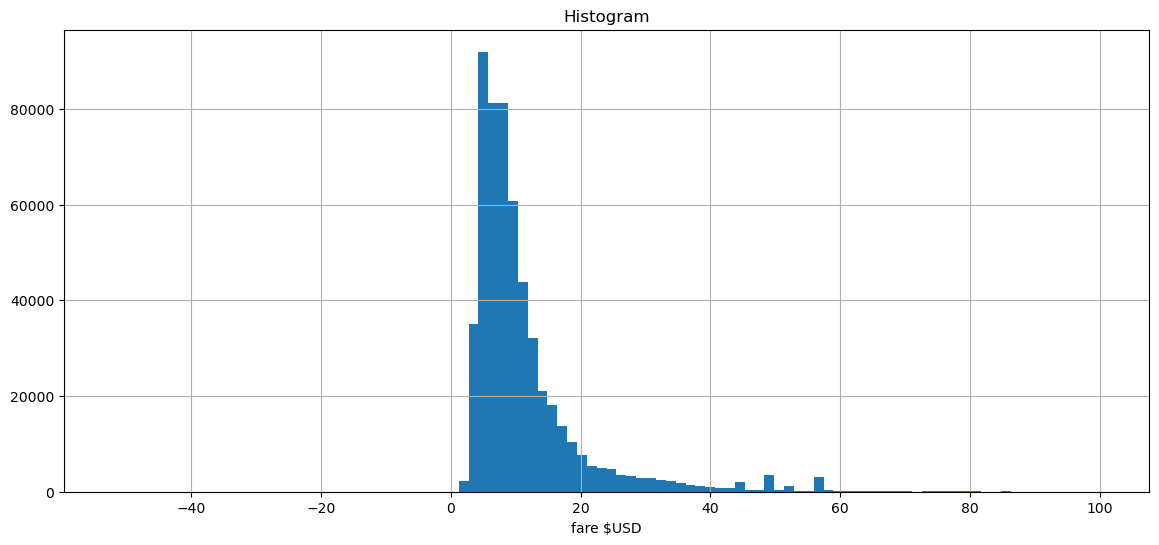

In [17]:
df[df.fare_amount<100].fare_amount.hist(bins = 100, figsize=(14,6));
plt.xlabel('fare $USD')
plt.title('Histogram')

## 3. Prepare Dataset for Training

- Split Training & Validation Set
- Fill/Remove Missing Values
- Extract Inputs & Outputs
   - Training
   - Validation
   - Test

### Split Training & Validation Set

We'll set aside 20% of the training data as the validation set, to evaluate the models we train on previously unseen data. 

Since the test set and training set have the same date ranges, we can pick a random 20% fraction.

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
train_df, val_df = train_test_split(df, test_size= 0.2, random_state = 42) 

In [20]:
len(train_df), len(val_df)

(441960, 110490)

### Fill/Remove Missing Values

There are no missing values in our sample, but if there were, we could simply drop the rows with missing values instead of trying to fill them (since we have a lot of training data)>

In [21]:
train_df = train_df.dropna()
val_df = val_df.dropna()

### Extract Inputs and Outputs

In [22]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [23]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [24]:
target_col = 'fare_amount'

#### Training

In [25]:
train_inputs = train_df[input_cols]
train_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
353352,-73.993652,40.741543,-73.977974,40.742352,4
360070,-73.993805,40.724579,-73.993805,40.724577,1
372609,-73.959160,40.780750,-73.969116,40.761231,1
550895,-73.952187,40.783951,-73.978645,40.772603,1
444151,-73.977112,40.746834,-73.991104,40.750403,2
...,...,...,...,...,...
110268,-73.987152,40.750633,-73.979073,40.763167,1
259178,-73.972656,40.764042,-74.013176,40.707841,2
365838,-73.991982,40.749767,-73.989845,40.720552,3
131932,-73.969055,40.761398,-73.990814,40.751327,1


In [26]:
train_targets = train_df[target_col]
train_targets

353352     6.0
360070     3.7
372609    10.0
550895     8.9
444151     7.3
          ... 
110268     9.3
259178    18.5
365838    10.1
131932    10.9
121958     9.5
Name: fare_amount, Length: 441960, dtype: float32

#### Validation

In [27]:
val_inputs = val_df[input_cols]
val_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
15971,-73.995834,40.759190,-73.973679,40.739086,1
149839,-73.977386,40.738335,-73.976143,40.751204,1
515867,-73.983910,40.749470,-73.787170,40.646643,1
90307,-73.790794,40.643463,-73.972252,40.690180,1
287032,-73.976593,40.761944,-73.991463,40.750309,2
...,...,...,...,...,...
467556,-73.968567,40.761238,-73.983406,40.750020,3
19482,-73.986725,40.755920,-73.985855,40.731170,1
186063,0.000000,0.000000,0.000000,0.000000,1
382260,-73.980057,40.760334,-73.872589,40.774298,1


In [28]:
val_targets = val_df[target_col]
val_targets

15971     14.000000
149839     6.500000
515867    49.570000
90307     49.700001
287032     8.500000
            ...    
467556     6.100000
19482      7.300000
186063     4.500000
382260    32.900002
18838     11.500000
Name: fare_amount, Length: 110490, dtype: float32

#### Test

In [29]:
test_inputs = test_df[input_cols]
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746139,1
3,-73.981163,40.767807,-73.990448,40.751635,1
4,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6
9910,-73.945511,40.803600,-73.960213,40.776371,6
9911,-73.991600,40.726608,-73.789742,40.647011,6
9912,-73.985573,40.735432,-73.939178,40.801731,6


## 4. Train Hardcoded & Baseline Models

- Hardcoded model: always predict average fare
- Baseline model: Linear regression 

For evaluation the dataset uses RMSE error: 
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

### Train & Evaluate Hardcoded Model

Let's create a simple model that always predicts the average.

In [30]:
import numpy as np 

In [31]:
class MeanRegressor():
    def fit(self, inputs, targets):
        self.mean = targets.mean()
    
    def predict(self, inputs):
        return np.full(inputs.shape[0],self.mean)

In [32]:
mean_model = MeanRegressor()

In [33]:
mean_model.fit(train_inputs, train_targets)

In [34]:
mean_model.mean

11.354714

In [35]:
train_preds = mean_model.predict(train_inputs)
train_preds

array([11.354714, 11.354714, 11.354714, ..., 11.354714, 11.354714,
       11.354714], dtype=float32)

In [36]:
val_preds = mean_model.predict(val_inputs)
val_preds

array([11.354714, 11.354714, 11.354714, ..., 11.354714, 11.354714,
       11.354714], dtype=float32)

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
def rmse(targets, preds):
    return mean_squared_error(targets, preds, squared = False)

In [39]:
train_rmse = rmse(train_targets, train_preds)
train_rmse

9.789782

In [40]:
val_rmse = rmse(val_targets, val_preds)
val_rmse

9.899954

Our dumb hard-coded model is off by 9.899. on average, which is pretty bad considering the average fare is \$11.35.

### Train & Evaluate Baseline Model

We'll traina linear regression model as our baseline, which tries to express the target as a weighted sum of the inputs.

In [41]:
from sklearn.linear_model import LinearRegression

In [42]:
linreg_model = LinearRegression()

In [43]:
linreg_model.fit(train_inputs, train_targets)

LinearRegression()

In [44]:
train_preds = linreg_model.predict(train_inputs)
train_preds

array([11.54623682, 11.28460949, 11.28413941, ..., 11.45891673,
       11.28428005, 11.28444733])

In [45]:
val_preds = linreg_model.predict(val_inputs)
val_preds

array([11.28432795, 11.28449549, 11.28478054, ..., 11.80449938,
       11.28443343, 11.28413233])

In [46]:
train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
train_rmse

9.78863266989743

In [47]:
val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
val_rmse

9.898088220645102

The linear regression model is off by $9.898, which isn't much better than simply predicting the average. 

This is mainly because the training data (geocoordinates) is not in a format that's useful for the model, and we're not using one of the most important columns: pickup date & time.

However, now we have a baseline that our other models should ideally beat.

## 5. Make Predictions and Submit to Kaggle

- Make predictions for test set
- Generate submissions CSV
- Submit to Kaggle
- Record in experiment tracking sheet

In [48]:
test_inputs[:6]

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746139,1
3,-73.981163,40.767807,-73.990448,40.751635,1
4,-73.966049,40.789776,-73.988564,40.744427,1
5,-73.960983,40.765549,-73.979179,40.740053,1


In [49]:
test_preds = linreg_model.predict(test_inputs)

In [50]:
submission_df = pd.read_csv('sample_submission_new_york_city_taxi_fare.csv')

In [51]:
submission_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


In [52]:
def generate_submission(test_preds, fname):
    sub_df = pd.read_csv('sample_submission_new_york_city_taxi_fare.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)

In [53]:
generate_submission(test_preds, 'linreg_submission.csv')

## 6. Feature Engineering


- Extract parts of date
- Remove outliers & invalid data
- Add distance between pickup & drop
- Add distance from landmarks

Exercise: We're going to apply all of the above together, but you should observer the effect of adding each feature individually.

### Extract Parts of Date

- Year
- Month
- Day
- Weekday
- Hour


In [54]:
def add_dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_day'] = df[col].dt.day
    df[col + '_weekday'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour
    

In [55]:
add_dateparts(train_df, 'pickup_datetime')

In [56]:
add_dateparts(val_df, 'pickup_datetime')

In [57]:
add_dateparts(test_df, 'pickup_datetime')

In [58]:
train_df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour
353352,6.0,2015-04-12 03:40:38+00:00,-73.993652,40.741543,-73.977974,40.742352,4,2015,4,12,6,3
360070,3.7,2011-01-26 19:21:00+00:00,-73.993805,40.724579,-73.993805,40.724577,1,2011,1,26,2,19
372609,10.0,2012-10-03 10:40:17+00:00,-73.959160,40.780750,-73.969116,40.761231,1,2012,10,3,2,10
550895,8.9,2012-03-14 13:44:27+00:00,-73.952187,40.783951,-73.978645,40.772603,1,2012,3,14,2,13
444151,7.3,2012-02-05 15:33:00+00:00,-73.977112,40.746834,-73.991104,40.750403,2,2012,2,5,6,15
...,...,...,...,...,...,...,...,...,...,...,...,...
110268,9.3,2009-09-06 16:12:00+00:00,-73.987152,40.750633,-73.979073,40.763167,1,2009,9,6,6,16
259178,18.5,2009-04-12 09:58:56+00:00,-73.972656,40.764042,-74.013176,40.707841,2,2009,4,12,6,9
365838,10.1,2012-07-12 19:30:00+00:00,-73.991982,40.749767,-73.989845,40.720552,3,2012,7,12,3,19
131932,10.9,2011-02-17 18:33:00+00:00,-73.969055,40.761398,-73.990814,40.751327,1,2011,2,17,3,18


### Add Distance Between Pickup and Drop

We can use the haversine distance: 
- https://en.wikipedia.org/wiki/Haversine_formula
- https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

In [59]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [60]:
def add_trip_distance(df):
    df['trip_distance'] = haversine_np(df['pickup_longitude'], df['pickup_latitude'], df['dropoff_longitude'], df['dropoff_latitude'])

In [61]:
%%time
add_trip_distance(train_df)

CPU times: total: 31.2 ms
Wall time: 59.1 ms


In [62]:
add_trip_distance(val_df)

In [63]:
add_trip_distance(test_df)

In [64]:
train_df.sample(6)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance
170685,9.7,2011-01-05 19:25:40+00:00,-73.979759,40.743370,-73.949326,40.781452,1,2011,1,5,2,19,4.946885
286784,12.9,2009-07-29 00:31:00+00:00,-73.982025,40.778687,-73.982025,40.778685,1,2009,7,29,2,0,0.000022
165742,27.0,2015-01-13 00:44:45+00:00,0.000000,0.000000,0.000000,0.000000,1,2015,1,13,1,0,0.000000
529149,36.5,2009-05-30 06:52:00+00:00,-73.958138,40.814709,-73.974113,40.657617,1,2009,5,30,5,6,17.508421
339951,4.9,2011-12-07 08:08:00+00:00,-73.940720,40.803238,-73.940720,40.803238,1,2011,12,7,2,8,0.000232
200777,14.1,2010-07-07 19:22:00+00:00,-74.005569,40.738815,-73.989273,40.680348,1,2010,7,7,2,19,6.640439


### Add Distance From Popular Landmarks

- JFK Airport
- LGA Airport
- EWR Airport
- Times Square
- Met Meuseum
- World Trade Center

We'll add the distance from drop location. 

In [65]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

In [66]:
def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
    lon, lat = landmark_lonlat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])
    

In [67]:
%%time
for a_df in [train_df, val_df, test_df]:
    for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)
        

CPU times: total: 359 ms
Wall time: 503 ms


In [68]:
train_df.sample(8)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
444354,12.5,2015-04-27 10:19:24+00:00,-73.998436,40.760578,-74.002869,40.725079,1,2015,4,27,0,10,3.962488,21.105313,12.281999,14.989176,6.898347,1.507971
120520,10.0,2013-12-11 23:57:35+00:00,-73.994873,40.720711,-73.949997,40.716214,2,2013,12,11,2,23,3.812967,16.708048,9.295646,19.145060,7.109072,5.061945
506688,14.9,2012-04-20 07:54:53+00:00,-73.961563,40.767632,-73.959587,40.808562,1,2012,4,20,4,7,4.551610,24.064003,8.013765,22.414567,3.254909,11.474071
473014,9.7,2012-01-27 18:06:00+00:00,-73.955627,40.764061,-73.981544,40.747177,1,2012,1,27,4,18,2.877274,20.790600,9.635476,17.470130,3.899305,4.524033
19672,8.5,2010-01-28 19:28:35+00:00,-73.951591,40.773632,-73.981010,40.782117,1,2010,1,28,3,19,2.649024,23.173239,9.023107,19.271048,1.528439,8.098960
29436,4.1,2009-06-04 21:02:00+00:00,-73.974983,40.751034,-73.974983,40.751033,5,2009,6,4,3,21,0.000025,20.587992,8.972435,18.141693,3.304582,5.185077
201681,9.7,2012-04-16 13:34:48+00:00,-73.985619,40.752869,-73.964157,40.764863,1,2012,4,16,0,13,2.245040,20.838163,7.704565,19.593600,1.617429,6.968718
155552,12.5,2015-02-16 10:08:53+00:00,-73.966980,40.793552,-73.972862,40.758724,1,2015,2,16,0,10,3.901610,20.964340,8.561910,18.642724,2.437134,5.999894


### Remove Outliers and Invalid Data

There seems to be some invalide data in each of the following columns:

- Fare amount
- Passenger count
- Pickup latitude & longitude
- Drop latitude & longitude

In [69]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000,441960.000000
mean,11.354714,-72.498627,39.909996,-72.508141,39.937865,1.684444,2011.740038,6.263920,15.732492,3.035813,13.506568,19.751764,193.147978,182.365206,191.412330,177.416092,178.902096
std,9.788187,11.826187,8.449581,12.422503,9.857420,1.344170,1.857024,3.434881,8.697374,1.950033,6.517710,371.299305,1223.614787,1226.672207,1228.515208,1228.388658,1228.487258
min,-52.000000,-1183.362793,-3084.490234,-3356.729736,-2073.150613,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.305535,0.116385,0.129259,0.031095,0.009334
25%,6.000000,-73.992027,40.734859,-73.991409,40.733968,1.000000,2010.000000,3.000000,8.000000,1.000000,9.000000,1.212450,20.535191,8.350965,16.502844,2.169888,3.642498
50%,8.500000,-73.981819,40.752613,-73.980171,40.753078,1.000000,2012.000000,6.000000,16.000000,3.000000,14.000000,2.116230,21.202076,9.575570,18.016353,3.818017,5.559662
75%,12.500000,-73.967186,40.767006,-73.963715,40.768045,2.000000,2013.000000,9.000000,23.000000,5.000000,19.000000,3.879673,21.948262,11.122069,19.953306,6.071750,7.814534
max,400.000000,2420.209473,404.899994,2467.752686,3351.403027,208.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,16913.444834,15057.674834,15074.642961,15074.714623,15077.613474,15072.109731


In [70]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_day,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751743,1.671273,2011.815816,6.857979,16.194170,2.852834,13.467420,3.433217,20.916707,9.675209,18.546655,4.512975,6.037621
std,0.042799,0.033542,0.039093,0.035435,1.278747,1.803347,3.353272,8.838482,1.994451,6.868584,3.969883,3.303942,3.295656,4.035818,4.018438,4.252537
min,-74.252190,40.573143,-74.263245,40.568973,1.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000009,0.402057,0.285510,0.284706,0.085728,0.040386
25%,-73.992500,40.736125,-73.991249,40.735254,1.000000,2010.000000,4.000000,9.000000,1.000000,8.000000,1.297281,20.513366,8.311562,16.520468,2.126326,3.669914
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,2012.000000,7.000000,16.000000,3.000000,15.000000,2.215669,21.181394,9.477792,18.024364,3.698360,5.541418
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,2014.000000,10.000000,25.000000,5.000000,19.000000,4.042928,21.909781,10.965471,19.880521,5.922760,7.757408
max,-72.986534,41.709557,-72.990967,41.696683,6.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,99.933359,134.497657,126.062486,149.400789,130.347048,138.619454


We'll use the following ranges:

- `fare_amount`: \$1 to \$500
- `longitudes`: -75 to -72
- `latitudes`: 40 to 42
- `passenger_count`: 1 to 6

In [71]:
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.) & 
              (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75) & 
              (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75) & 
              (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40) & 
              (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40) & 
              (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1) & 
              (df['passenger_count'] <= 6)]

In [72]:
train_df = remove_outliers(train_df)

In [73]:
val_df = remove_outliers(val_df)

## 7. Train & Evaluate Different Models

We'll train each of the following & submit predictions to Kaggle:

- Ridge Regression
- Random Forests
- Gradient Boosting



### Split Inputs & Targets

In [74]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [75]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month', 'pickup_datetime_day',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance']

In [76]:
target_col = 'fare_amount'

In [77]:
train_inputs = train_df[input_cols]
train_targets= train_df[target_col]

In [78]:
val_inputs = val_df[input_cols]
val_targets= val_df[target_col]

In [79]:
test_inputs = test_df[input_cols]

Let's define a helper function to evaluate models and generate test predictions.

In [80]:
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    val_preds = model.predict(val_inputs)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    return train_rmse, val_rmse, train_preds, val_preds

In [81]:
def predict_and_submit(model, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv('sample_submission_new_york_city_taxi_fare.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

### Ridge Regression

In [82]:
from sklearn.linear_model import Ridge

In [83]:
model1 = Ridge(random_state=42)

In [84]:
%%time
model1.fit(train_inputs, train_targets)

CPU times: total: 156 ms
Wall time: 169 ms


Ridge(random_state=42)

In [85]:
evaluate(model1)

(5.049312855022607,
 5.217863164084475,
 array([ 8.12926895,  4.11625204,  8.75052428, ..., 10.47189549,
         8.23053339, 10.58672574]),
 array([10.91970437,  6.20497332, 46.21797207, ...,  8.04644756,
        25.56873019,  8.45308844]))

In [86]:
predict_and_submit(model1, 'ridge_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.081831
1,2015-01-27 13:08:24.0000003,11.399684
2,2011-10-08 11:53:44.0000002,5.356914
3,2012-12-01 21:12:12.0000002,8.763991
4,2012-12-01 21:12:12.0000003,14.610180
...,...,...
9909,2015-05-10 12:37:51.0000002,9.025113
9910,2015-01-12 17:05:51.0000001,11.218273
9911,2015-04-19 20:44:15.0000001,47.926257
9912,2015-01-31 01:05:19.0000005,22.600176


### Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [87]:
from sklearn.ensemble import RandomForestRegressor

In [88]:
model2 = RandomForestRegressor(max_depth = 10, n_jobs = -1, random_state= 42, n_estimators= 50 )


In [89]:
model2.fit(train_inputs, train_targets)

RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=42)

In [90]:
evaluate(model2)

(3.5979272803236033,
 4.162992374769893,
 array([ 7.04561969,  9.16841263,  9.10837664, ..., 10.38572951,
         7.74169069, 10.38922928]),
 array([12.53333721,  6.14758144, 47.32745299, ...,  8.33103424,
        29.15652571,  8.2638333 ]))

In [91]:
predict_and_submit(model2, 'rf_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.507307
1,2015-01-27 13:08:24.0000003,10.507307
2,2011-10-08 11:53:44.0000002,5.052405
3,2012-12-01 21:12:12.0000002,8.466582
4,2012-12-01 21:12:12.0000003,14.344346
...,...,...
9909,2015-05-10 12:37:51.0000002,8.835443
9910,2015-01-12 17:05:51.0000001,12.520002
9911,2015-04-19 20:44:15.0000001,55.266349
9912,2015-01-31 01:05:19.0000005,21.551546


### Gradient Boosting

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [92]:
from xgboost import XGBRegressor

In [93]:
model3 = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')

In [94]:
%%time
model3.fit(train_inputs, train_targets)

CPU times: total: 27.5 s
Wall time: 7.13 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [95]:
evaluate(model3)

(3.1142666,
 3.9677556,
 array([ 6.2575097,  8.435964 , 10.496409 , ..., 11.761659 ,  9.359157 ,
        10.077442 ], dtype=float32),
 array([14.8424   ,  6.0813756, 48.09645  , ...,  7.7121677, 30.280682 ,
         8.897864 ], dtype=float32))

In [96]:
predict_and_submit(model3, 'xgb_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.476058
1,2015-01-27 13:08:24.0000003,11.393686
2,2011-10-08 11:53:44.0000002,4.716984
3,2012-12-01 21:12:12.0000002,8.573630
4,2012-12-01 21:12:12.0000003,16.497250
...,...,...
9909,2015-05-10 12:37:51.0000002,9.047094
9910,2015-01-12 17:05:51.0000001,11.033975
9911,2015-04-19 20:44:15.0000001,53.698120
9912,2015-01-31 01:05:19.0000005,19.612867


## 8. Tune Hyperparmeters

https://towardsdatascience.com/mastering-xgboost-2eb6bce6bc76


We'll tune parameters for the XGBoost model. Here’s a strategy for tuning hyperparameters:

- Tune the most important/impactful hyperparameter first e.g. n_estimators

- With the best value of the first hyperparameter, tune the next most impactful hyperparameter

- And so on, keep training the next most impactful parameters with the best values for previous parameters...

- Then, go back to the top and further tune each parameter again for further marginal gains

- Hyperparameter tuning is more art than science, unfortunately. Try to get a feel for how the parameters interact with each other based on your understanding of the parameter…

Let's define a helper function for trying different hyperparameters.

In [97]:
import matplotlib.pyplot as plt

def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    model = ModelClass(**params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [98]:
best_params = {
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'reg:squarederror'
}

### No. of Trees

CPU times: total: 3min 25s
Wall time: 53.3 s


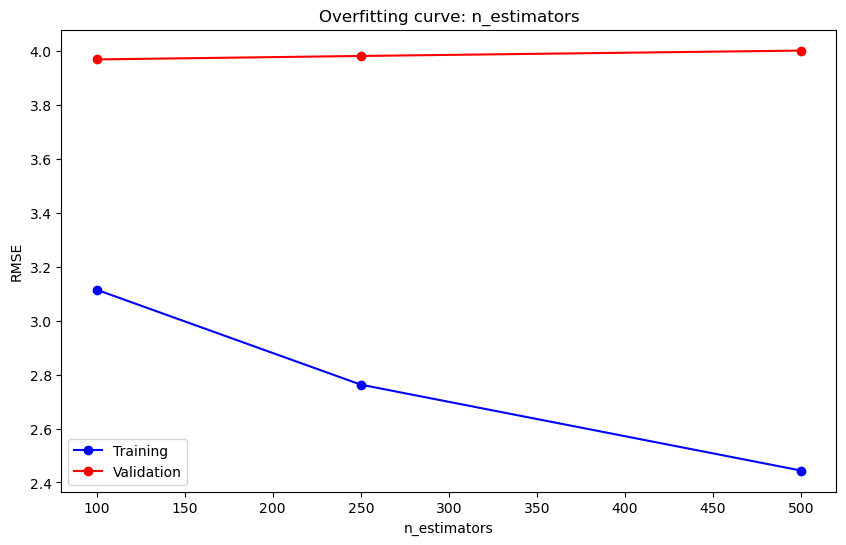

In [99]:
%%time 
test_param_and_plot(XGBRegressor, 'n_estimators', [100, 250, 500], **best_params)


In [100]:
best_params['n_estimators'] = 250

### Max Depth

CPU times: total: 2min 9s
Wall time: 31.4 s


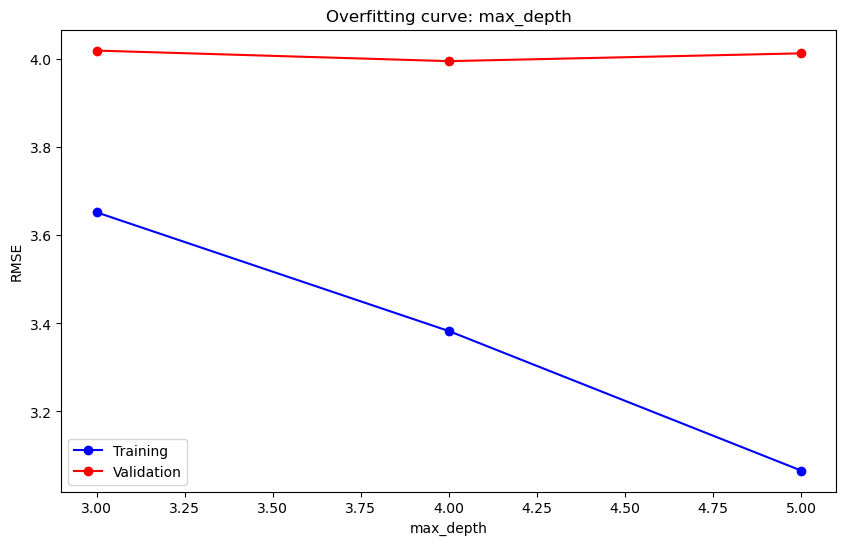

In [101]:
%%time 
test_param_and_plot(XGBRegressor, 'max_depth', [3, 4, 5], **best_params)


In [102]:
best_params['max_depth'] = 5

### Learning Rate

CPU times: total: 2min 32s
Wall time: 31.1 s


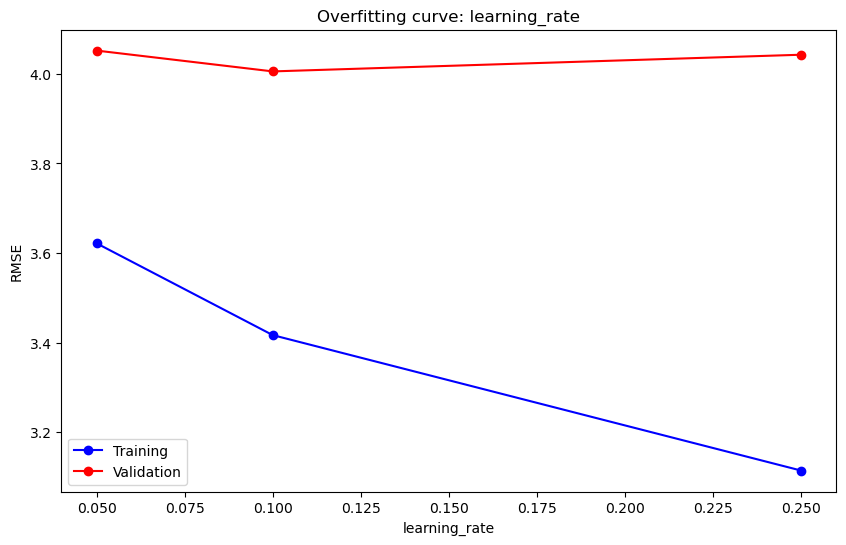

In [103]:
%%time
test_param_and_plot(XGBRegressor, 'learning_rate', [0.05, 0.1, 0.25], **best_params)


In [104]:
best_params['learning_rate'] = 0.25

### Other Parameters

Similarly we can experiment with other parameters. 

Here's a set of parameters that works well:


In [105]:
xgb_model_final = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42,
                               n_estimators=500, max_depth=5, learning_rate=0.1, 
                               subsample=0.8, colsample_bytree=0.8)


In [106]:
%%time
xgb_model_final.fit(train_inputs, train_targets)

CPU times: total: 1min 58s
Wall time: 25.7 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [107]:
evaluate(xgb_model_final)

(3.1829684,
 3.9909995,
 array([ 6.3535433,  7.207315 , 10.053992 , ..., 11.4699955,  9.132495 ,
        10.337278 ], dtype=float32),
 array([14.469879 ,  6.0205135, 47.64456  , ...,  7.5639315, 31.012997 ,
         8.741738 ], dtype=float32))

In [108]:
predict_and_submit(xgb_model_final, 'xgb_tuned_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.973768
1,2015-01-27 13:08:24.0000003,11.116068
2,2011-10-08 11:53:44.0000002,4.980051
3,2012-12-01 21:12:12.0000002,8.786870
4,2012-12-01 21:12:12.0000003,15.923136
...,...,...
9909,2015-05-10 12:37:51.0000002,8.628636
9910,2015-01-12 17:05:51.0000001,11.819692
9911,2015-04-19 20:44:15.0000001,54.450031
9912,2015-01-31 01:05:19.0000005,19.788847



This puts us at the 460th position out of 1483 i.e. top 30%. This is pretty amazing considering:

- We are using just 1% of the training data
- We are only using a single model (most top submissions use ensembles)
- Our best model takes just 10 minutes to train (as oppposed to hours/days)
- We haven't fully optimized the hyperparameters yet

## References

* Dataset: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview
* Missing semester (Shell scripting): https://missing.csail.mit.edu/
* Opendatsets library: https://github.com/JovianML/opendatasets 
* EDA project from scratch: https://www.youtube.com/watch?v=kLDTbavcmd0
* GeoPy: https://geopy.readthedocs.io/en/stable/#module-geopy.distance 
* Blog post by Allen Kong: https://towardsdatascience.com/nyc-taxi-fare-prediction-605159aa9c24 
* Machine Learning with Python: Zero to GBMs - https://zerotogbms.com 
* Experiment tracking spreadsheet: https://bit.ly/mltrackingsheet 
* Pandas datetime components: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components 
* Haversine distance: https://en.wikipedia.org/wiki/Haversine_formula 
* Haversine distance with Numpy: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas 

